In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , MaxPooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.applications import VGG19,VGG16
import cv2
import os
import random
import tensorflow as tf
import numpy as np
import pandas as pd

from tensorflow.keras.applications.imagenet_utils import preprocess_input
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.models import load_model # to save the model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, losses
from tensorflow.random import set_seed

import requests
import urllib
from io import BytesIO
from PIL import Image

In [2]:
data = pd.read_csv("../input/data-amazon-product-image-250-new/data_amazon_small.csv").drop('Unnamed: 0', axis=1)
print("Data Dimensions are: ", data.shape)
print("Columns: ", data.columns)
data.sample(5)

Data Dimensions are:  (5000, 6)
Columns:  Index(['categories', 'imUrl', 'price', 'asin', 'description', 'title'], dtype='object')


,categories,imUrl,price,asin,description,title
4329,Camera & Photo,http://ecx.images-amazon.com/images/I/41MQTJQN...,11.57,B00005UKBD,Stay ahead of the digital curve with the Sony ...,Sony DSCF707 Cyber-shot 5MP Digital Still Came...
2901,"Arts, Crafts & Sewing",http://ecx.images-amazon.com/images/I/51%2B-HG...,2.79,B000SMZ050,Faceted wood beads in a flattened round shape....,Coin Shape Wood Beads 8X5mm /16 In Strand
1824,Health & Personal Care,http://ecx.images-amazon.com/images/I/31suqOER...,34.95,B0007ZHINU,"5 1/2"" Single Thinning Shear with adjustable s...",Body Toolz 5 1/2&quot; Stainless Steel Thinnin...
734,Pet Supplies,http://ecx.images-amazon.com/images/I/515JENX7...,NaN,B0002QX3U6,Constructed of heavy-duty materials and a prot...,Bamboo Combat Big Kahuna Dog Toy
3369,Home &amp; Kitchen,http://ecx.images-amazon.com/images/I/41G3J0C1...,34.95,B000IKEV6G,Mala Beads are a Buddhist tool of meditation. ...,Traditional Sandalwood Mala Beads - Large 14mm...


**Data Visualization**

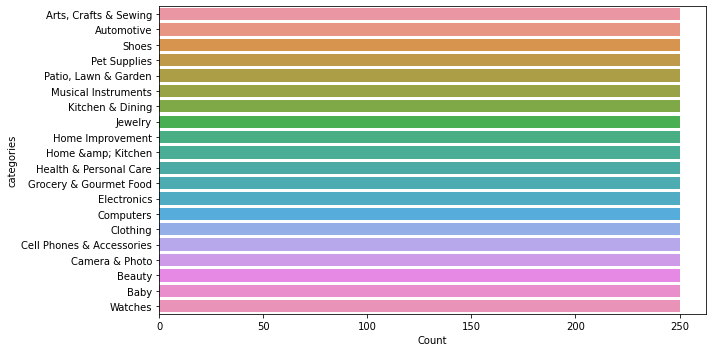

In [3]:
data_categories = data.groupby('categories')['imUrl'].count().reset_index().rename(columns={'imUrl': 'Count'})
data_categories = data_categories.sort_values(by='Count',ascending=False)

f, ax = plt.subplots(figsize=(10, 5))
g = sns.barplot(data=data_categories.head(20), y='categories', x='Count')
f.tight_layout()
plt.show()

**Display image the actual image**

In [4]:
def display_img(url):
    """
    This functions takes the image url and return the picture of the image
    """
    # we get the url of the apparel and download it
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # we will display it in notebook 
    return plt.imshow(img)

Baby


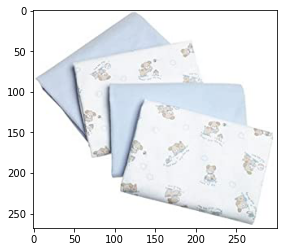

In [5]:
display_img(data['imUrl'][186])
print(data['categories'][186])

**Since our data has images stored as a link in a csv file, we will first create a function which extracts the images from the links and convert them into arrays**

In [6]:
categories = ['Baby','Home Improvement','Pet Supplies','Kitchen & Dining',
              'Automotive','Computers','Cell Phones & Accessories',
              'Health & Personal Care','Beauty','Grocery & Gourmet Food',
              'Patio, Lawn & Garden','Arts, Crafts & Sewing',
              'Musical Instruments','Home &amp; Kitchen','Clothing',
              'Jewelry','Electronics','Camera & Photo','Watches','Shoes']

In [7]:
image_array = np.load('../input/data-amazon-product-image-250-new/image_array.npy')
label_array = np.load('../input/data-amazon-product-image-250-new/label_array.npy')

In [8]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


# **Image Classification**

In [9]:
# from sklearn.preprocessing import LabelBinarizer
# label_binarizer = LabelBinarizer()
# y = label_binarizer.fit_transform(labels)

In [10]:
train_images, test_images, train_labels, test_labels=train_test_split(image_array, label_array,
                                                                      test_size=0.1, random_state=42)
train_images, val_images, train_labels, val_labels=train_test_split(train_images, train_labels,
                                                                      test_size=0.2, random_state=42)

# Normalize pixel values to be between 0 and 1
train_images, test_images, val_images = train_images / 255.0, test_images / 255.0, val_images / 255.0

print('Number of   training samples : {}'.format(train_images.shape[0]))
print('Number of validation samples : {}'.format(val_images.shape[0]))
print('Number of       test samples : {}'.format(test_images.shape[0]))

Number of   training samples : 3592
Number of validation samples : 899
Number of       test samples : 500


In [11]:
with strategy.scope():
    pre_trained_model = VGG19(input_shape=(224,224,3), include_top=False, weights="imagenet")

    for layer in pre_trained_model.layers[:19]:
        layer.trainable = False

    model = Sequential([
        pre_trained_model,
        MaxPool2D((2,2), strides = 2),
        Flatten(),
        Dense(20, activation='softmax')])
    
    model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
model.summary()

2022-10-07 06:33:20.804690: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-07 06:33:20.937236: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-07 06:33:20.938143: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-07 06:33:20.939721: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

80150528/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 20)                92180     
Total params: 20,116,564
Trainable params: 4,811,796
Non-trainable params: 15,304,768
_________________________________________________________________


In [12]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, 
                                            verbose=1,factor=0.3, min_lr=0.000001)

In [13]:
history = model.fit(train_images, train_labels, batch_size = 64 , epochs = 15, 
                    validation_data = (val_images,  val_labels) ,callbacks = [learning_rate_reduction])

2022-10-07 06:33:26.302956: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2162786304 exceeds 10% of free system memory.
2022-10-07 06:33:28.921648: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2162786304 exceeds 10% of free system memory.
2022-10-07 06:33:30.714596: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
/opt/conda/lib/python3.7/site-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


Epoch 1/15


2022-10-07 06:33:32.265141: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


57/57 [==============================] - ETA: 0s - loss: 2.5569 - accuracy: 0.2584

2022-10-07 06:33:52.804967: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 541298688 exceeds 10% of free system memory.
2022-10-07 06:33:53.446688: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 541298688 exceeds 10% of free system memory.


57/57 [==============================] - 26s 244ms/step - loss: 2.5569 - accuracy: 0.2584 - val_loss: 2.2066 - val_accuracy: 0.3671
Epoch 2/15
57/57 [==============================] - 11s 186ms/step - loss: 1.6238 - accuracy: 0.5237 - val_loss: 2.0717 - val_accuracy: 0.3971
Epoch 3/15
57/57 [==============================] - 11s 186ms/step - loss: 1.0635 - accuracy: 0.7252 - val_loss: 2.0427 - val_accuracy: 0.4093
Epoch 4/15
57/57 [==============================] - 11s 188ms/step - loss: 0.6356 - accuracy: 0.8692 - val_loss: 2.0712 - val_accuracy: 0.4116
Epoch 5/15
57/57 [==============================] - 11s 186ms/step - loss: 0.3347 - accuracy: 0.9596 - val_loss: 2.0678 - val_accuracy: 0.4327
Epoch 6/15
57/57 [==============================] - 11s 186ms/step - loss: 0.1772 - accuracy: 0.9905 - val_loss: 2.1561 - val_accuracy: 0.4349
Epoch 7/15
57/57 [==============================] - 11s 189ms/step - loss: 0.0901 - accuracy: 0.9975 - val_loss: 2.1801 - val_accuracy: 0.4305
Epoch 8/15

In [14]:
# saving it in a '.h5' format file which would be used for the AI Demo during the presentation
model.save('model_vgg19.h5')

In [15]:
print("Loss of the model is - " , model.evaluate(test_images, test_labels)[0])
print("Accuracy of the model is - " , model.evaluate(test_images, test_labels)[1]*100 , "%")

2022-10-07 06:36:26.239049: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 301056000 exceeds 10% of free system memory.


16/16 [==============================] - 6s 203ms/step - loss: 2.4015 - accuracy: 0.4300
Loss of the model is -  2.4014647006988525
16/16 [==============================] - 1s 76ms/step - loss: 2.4015 - accuracy: 0.4300
Accuracy of the model is -  43.00000071525574 %


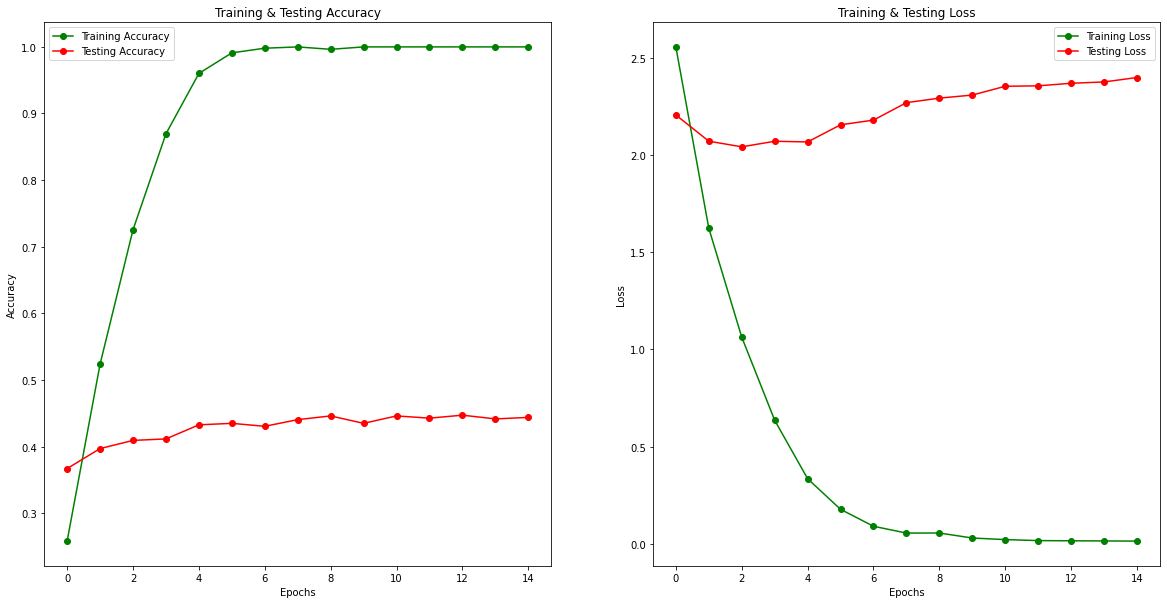

In [16]:
epochs = [i for i in range(15)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [17]:
predictions = np.argmax(model.predict(test_images), axis=1) # this will pick the value in an array having the maximum score
predictions[:10]

array([ 4, 15,  8,  5, 10,  9,  8, 14,  5, 14])

In [18]:
print(classification_report(test_labels.astype(str), predictions.astype(str), target_names = categories))

                           precision    recall  f1-score   support

                     Baby       0.53      0.47      0.50        34
         Home Improvement       0.15      0.14      0.15        28
             Pet Supplies       0.28      0.33      0.30        24
         Kitchen & Dining       0.27      0.20      0.23        20
               Automotive       0.32      0.48      0.39        23
                Computers       0.19      0.25      0.22        16
Cell Phones & Accessories       0.44      0.52      0.48        21
   Health & Personal Care       0.71      0.78      0.75        32
                   Beauty       0.48      0.48      0.48        21
   Grocery & Gourmet Food       0.42      0.53      0.47        15
     Patio, Lawn & Garden       1.00      0.79      0.88        29
    Arts, Crafts & Sewing       0.67      0.80      0.73        20
      Musical Instruments       0.36      0.24      0.29        34
       Home &amp; Kitchen       0.15      0.10      0.12     

<AxesSubplot:>

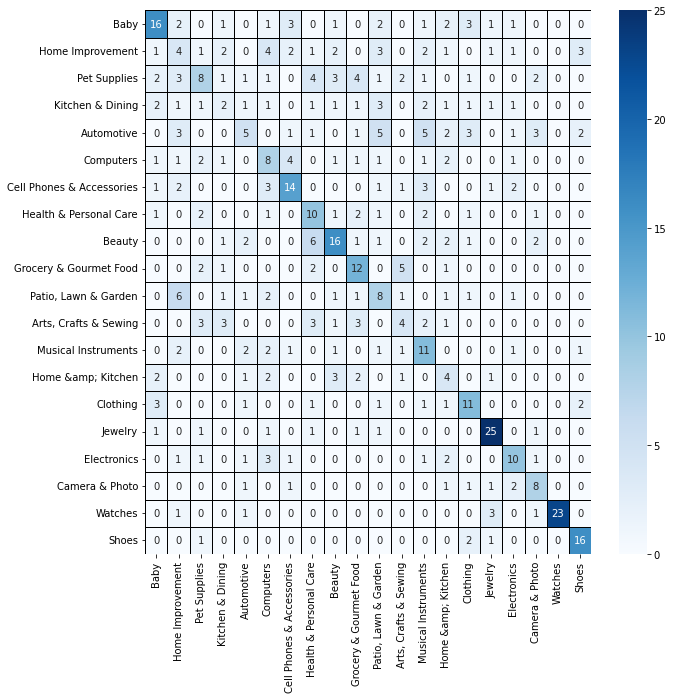

In [19]:
cm = confusion_matrix(test_labels,predictions)

cm = pd.DataFrame(cm , index = categories , columns = categories)
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='', 
            xticklabels = categories , yticklabels =categories)

In [20]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(categories)):
    if(test_labels[i] == predictions[i]):
        prop_class.append(i)
    if(len(categories)==8):
        break

i=0
for i in range(len(categories)):
    if(test_labels[i] != predictions[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

**CORRECTLY CLASSIFIED IMAGES**

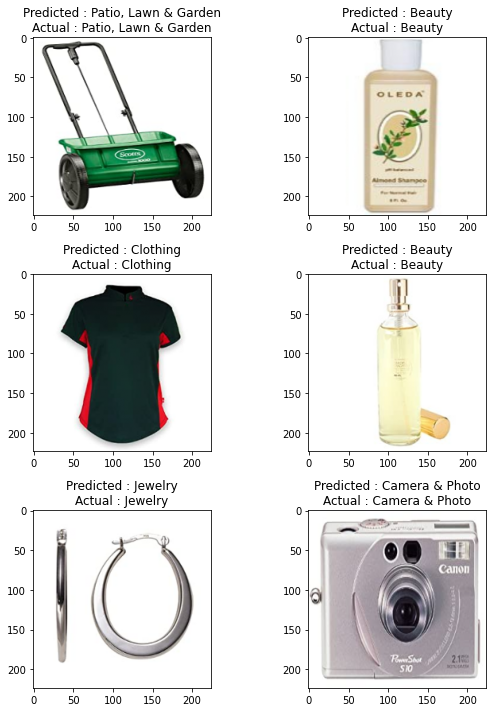

In [21]:
count=0
fig,ax=plt.subplots(3,2)
fig.set_size_inches(10,10)
for i in range (3):
    for j in range (2):
        ax[i,j].imshow(test_images[prop_class[count]])
        ax[i,j].set_title("Predicted : "+ categories[predictions[prop_class[count]]] +"\n"+"Actual : "+ categories[test_labels[prop_class[count]]])
        plt.tight_layout()
        count+=1

**INCORRECTLY CLASSIFIED IMAGES**

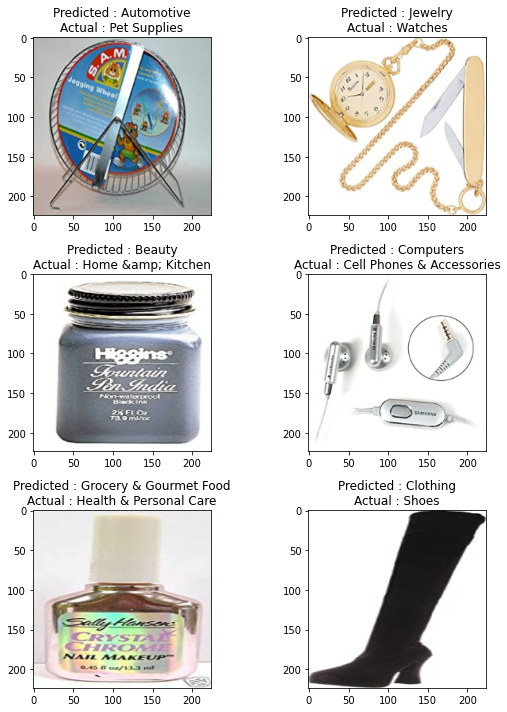

In [22]:
count=0
fig,ax=plt.subplots(3,2)
fig.set_size_inches(10,10)
for i in range (3):
    for j in range (2):
        ax[i,j].imshow(test_images[mis_class[count]])
        ax[i,j].set_title("Predicted : "+categories[predictions[mis_class[count]]]+"\n"+"Actual : "+categories[test_labels[mis_class[count]]])
        plt.tight_layout()
        count+=1